[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/repos-especializacion-UdeA/trabajo-final_AA1/blob/main/notebooks_pasos_previos/05_arboles_decision_random_forest_clasificacion.ipynb)

# Árboles de Decisión Random Forest (Clasificación)

## Autores

* Jairo Agudelo M.
* Henry Arcila.

## Descripción corta del dataset

El dataset a trabajar [db1_rms_prep.csv](./datasets_tarea/db1_rms_prep.csv) es uno de los dataset resultantes de la etapa previa de preparacion del dataset ([link](01_preparacion_dataset_clasificacion.ipynb)). Cada entrada de la base de datos contiene los valores RMS de cada uno de los 10 sensores EMG para una ventana de tiempo de 30 muestras de señal y la postura a la cual se asocia esta venta. A continuación se describen cada una de las columnas de la muestra.

Esta base de datos se describe a continuación:

| Columna               | Descripción                                       | Ejemplo   |
|:----------------------|:--------------------------------------------------|:----------|
| `emg1`                | Valor RMS sensor 1                                | 0.052510  | 
| `emg2`                | Valor RMS sensor 2                                | 0.002414  |	
| `emg3`                | Valor RMS sensor 3                                | 0.002445  |
| `emg4`                | Valor RMS sensor 4                                | 0.002417  |
| `emg5`                | Valor RMS sensor 5                                | 0.002400  |
| `emg6`                | Valor RMS sensor 6                                | 0.006204  |
| `emg7`                | Valor RMS sensor 7                                | 0.0024    |
| `emg8`                | Valor RMS sensor 8                                | 0.041218  |
| `emg9`                | Valor RMS sensor 9                                | 0.0024    |
| `emg1p`               | Valor RMS sensor 10                               | 0.019526  |
| `label`               | Numero de la postura realizada  (1 - 12)          | 5         |

Este dataset sera empleado para realizar el entrenamiento y test del modelo.

## Objetivo a desarrollar

> Utilizar el método de clasificación por arboles de decisión Random Forest para identificar el tipo de postura de mano asociado a una señal electromiográfica superficial, a partir de una muestra localizada en una ventana de tiempo.

## Resumen del proceso realizado

To Do...

## Desarrollo de experimentos

## 1. Librerias y configuraciones previas


In [2]:
# Determinacion si el archivo se va a ejecutar desde colab o local y configuracion de los elementos necesarios para la ejecucion
import sys
import os

# Path del notebook
notebook_path = "."
print(notebook_path)
try:
    import google.colab
    !git clone https://github.com/repos-especializacion-UdeA/trabajo-final_AA1.git
    %cd /content/trabajo-final_AA1/notebooks_pasos_previos   
    %pwd
    ruta_base = '/content/trabajo-final_AA1/notebooks_pasos_previos/'
    sys.path.append(ruta_base)
except ImportError:
    print("El notebook no se está ejecutando en Google Colab.")
    ruta_base = './'

.
El notebook no se está ejecutando en Google Colab.


In [3]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np


# Almacenar en caché los resultados de funciones en el disco
# ==============================================================================
import joblib


# Gestion de librerias
# ==============================================================================
from importlib import reload


# Matemáticas y estadísticas
# ==============================================================================
import math


# Preprocesado y modelado
# ==============================================================================
import math

#Separar los datos entrenamiento y prueba
from sklearn.model_selection import train_test_split


#Escalar Variables
from sklearn.preprocessing import MinMaxScaler


#Evaluación del modelo
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


#Creación de modelo
from sklearn.ensemble import RandomForestClassifier


#configuracion de hiperparámetros
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## 2. Funciones

In [4]:
#reload(utils.funciones)

# Funciones externas
# ==============================================================================
from utils.funciones1 import multiple_plot, plot_roc_curve

## 3. Carga del dataset

In [5]:
#Se crea un dataframe d con los datos obtenidos de archivo de entrada
DATA_PATH = './datasets_tarea/'
d=pd.read_csv(DATA_PATH + 'db1_rms_prep.csv')

In [6]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16250 entries, 0 to 16249
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   emg_1   16250 non-null  float64
 1   emg_2   16250 non-null  float64
 2   emg_3   16250 non-null  float64
 3   emg_4   16250 non-null  float64
 4   emg_5   16250 non-null  float64
 5   emg_6   16250 non-null  float64
 6   emg_7   16250 non-null  float64
 7   emg_8   16250 non-null  float64
 8   emg_9   16250 non-null  float64
 9   emg_10  16250 non-null  float64
 10  label   16250 non-null  int64  
dtypes: float64(10), int64(1)
memory usage: 1.4 MB


## 4. Visualización de datos

### Variables de entrada

In [7]:
#Lista de variables categóricas
catCols = d.select_dtypes(include = ["object", 'category']).columns.tolist()

d[catCols].head(2)

""
0
1


In [8]:
#Lista de variables numéricas

numCols=d.select_dtypes(include = ['float64','float64','int32','int64']).columns.tolist()

d[numCols].head(2)

,emg_1,emg_2,emg_3,emg_4,emg_5,emg_6,emg_7,emg_8,emg_9,emg_10,label
0,0.516068,0.580968,0.173756,0.068346,0.031557,0.002400,0.002447,0.049063,0.608643,0.006596,0
1,0.123792,0.290991,0.007430,0.002466,0.002441,0.002399,0.002422,0.008951,0.002594,0.002414,0


In [9]:
##Visualización de frecuencia de instancias para variables categóricas
#multiple_plot(3, d , catCols, None, 'countplot', 'Frecuencia de instancias para variables categóricas',30)

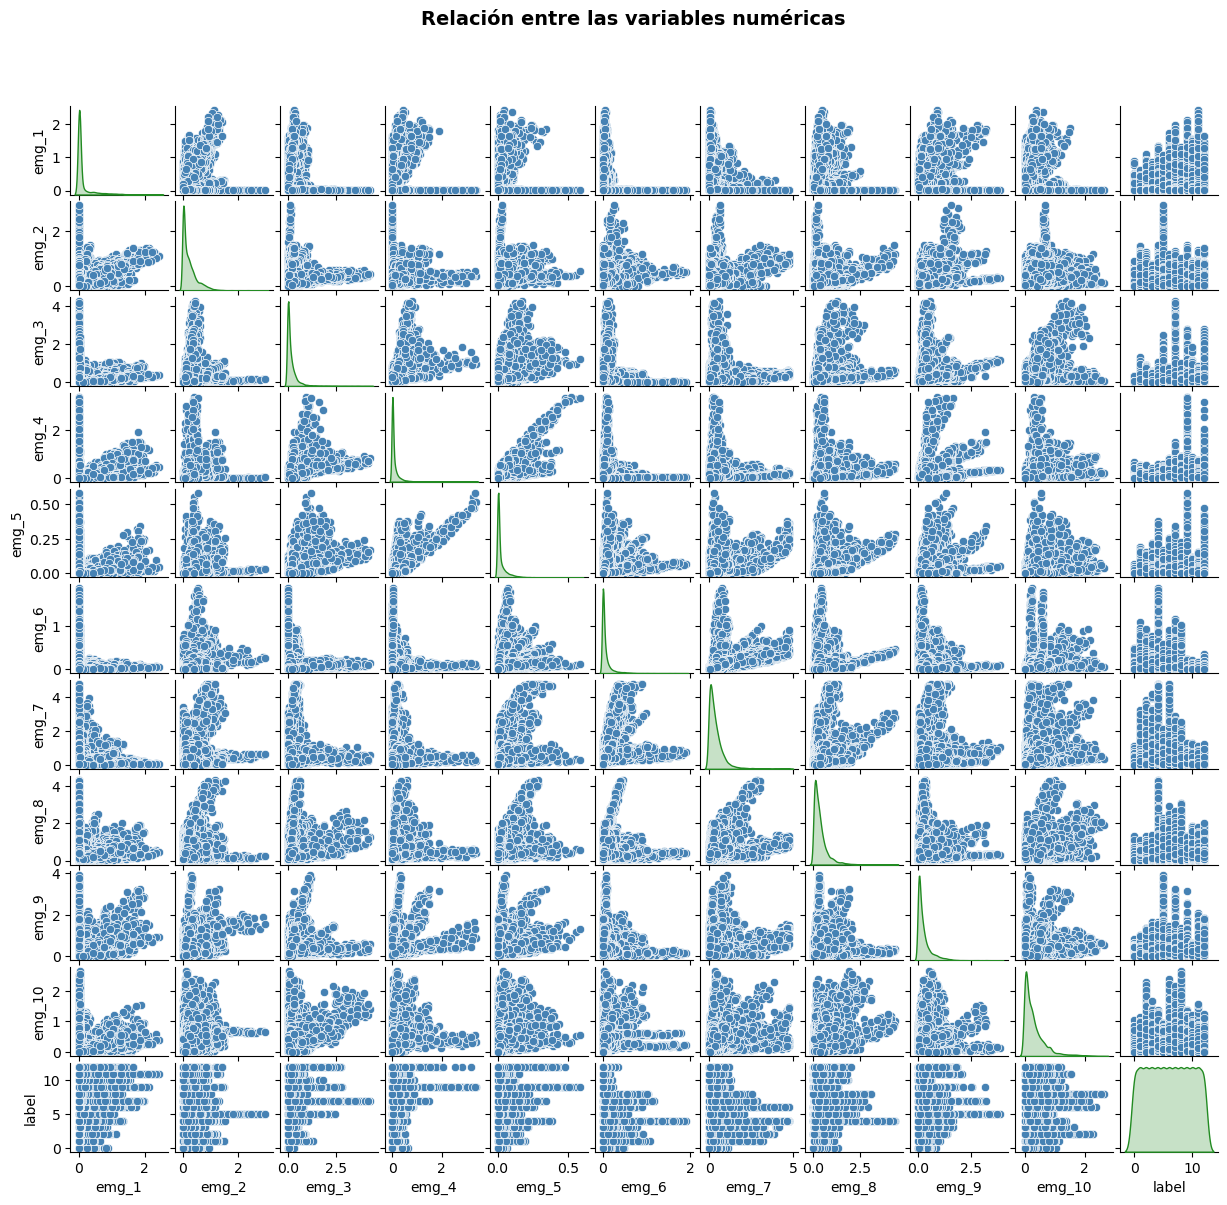

In [10]:
##Visualización de variables numéricas
multiple_plot(1, d , numCols, None, 'scatterplot', 'Relación entre las variables numéricas',30)

In [11]:
#Eliminar la variable de salida de la lista de variable numéricas
numCols.remove('label')

### Variable de salida

In [12]:
# Distriución de la variable de salida

d.groupby('label').label.count().sort_values(ascending=False)

label
0     1250
1     1250
2     1250
3     1250
4     1250
5     1250
6     1250
7     1250
8     1250
9     1250
10    1250
11    1250
12    1250
Name: label, dtype: int64

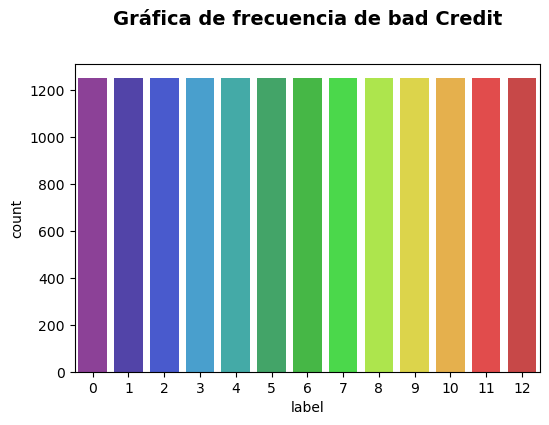

In [13]:
##Visualización de la variable de salida
multiple_plot(1, d , None, 'label', 'countplot', 'Gráfica de frecuencia de bad Credit',0)

## 5. Transformación de datos

### Creación de variables Dummies 

In [14]:
# Aplicación de la función de usuario Dummies: one-hot encoding

d =pd.get_dummies(d, drop_first=1)

d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16250 entries, 0 to 16249
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   emg_1   16250 non-null  float64
 1   emg_2   16250 non-null  float64
 2   emg_3   16250 non-null  float64
 3   emg_4   16250 non-null  float64
 4   emg_5   16250 non-null  float64
 5   emg_6   16250 non-null  float64
 6   emg_7   16250 non-null  float64
 7   emg_8   16250 non-null  float64
 8   emg_9   16250 non-null  float64
 9   emg_10  16250 non-null  float64
 10  label   16250 non-null  int64  
dtypes: float64(10), int64(1)
memory usage: 1.4 MB


## 6. Creación del modelo

### Dividir el conjunto de datos

In [15]:
#Se establece las variables de entrada 'X' y la variable de salida 'y'

X = d.drop(columns ='label')
y = d['label']

# la validación cruzada se realiza sobre todo el dataset
X_Completo = X
y_Completo = y

### Escalar Variables

In [16]:
#Se establecen las variables numéricas a escalar

#Num_vars se le asigna la lista con las variables numerivas para posteriormente escalarlas
num_vars = numCols

print(num_vars)

['emg_1', 'emg_2', 'emg_3', 'emg_4', 'emg_5', 'emg_6', 'emg_7', 'emg_8', 'emg_9', 'emg_10']


In [17]:
#Se establecen las variables numéricas a escalar

#Num_vars se le asigna la lista con las variables numerivas para posteriormente escalarlas
num_vars = numCols

# Se crea un objeto MinMaxScaler
scaler = MinMaxScaler()

# Se escalan los valores del dataset entrenamiento y prueba de las columnas numéricas
X_Completo[num_vars] = scaler.fit_transform(X_Completo[num_vars])

X_Completo[num_vars].head()

,emg_1,emg_2,emg_3,emg_4,emg_5,emg_6,emg_7,emg_8,emg_9,emg_10
0,0.211498,0.196628,0.040547,0.020198,0.053329,0.001053,0.000383,0.011048,0.156578,0.002385
1,0.050435,0.098427,0.001685,0.000636,0.003507,0.001052,0.000378,0.001837,0.000580,0.000798
2,0.001837,0.000699,0.000515,0.000629,0.003920,0.010672,0.118151,0.024919,0.000529,0.022405
3,0.000786,0.000699,0.000545,0.000629,0.003520,0.001047,0.001723,0.009172,0.000532,0.002470
4,0.001361,0.073515,0.001600,0.000618,0.003901,0.001078,0.056688,0.033467,0.000541,0.001048


In [18]:
# Guardar el scaler
joblib.dump(scaler, './modelos/scaler/minmaxFull_label.pkl')

['./modelos/scaler/minmaxFull_label.pkl']

### Creación del modelo

#### 6.1 Grid Search basado en out-of-bag score

In [19]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'n_estimators': [150, 200, 250],
                 'max_features': [5, 7, 9],
                 'max_depth'   : [None, 3, 10, 20],
                 'criterion'   : ['gini', 'entropy']
                }
            )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_accuracy': []}

for params in param_grid:
    
    modelo = RandomForestClassifier(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )
    
    modelo.fit(X_Completo, y_Completo)
    
    
    resultados['params'].append(params)
    resultados['oob_accuracy'].append(modelo.oob_score_)
    print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')

Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 200} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 250} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'n_estimators': 200} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'n_estimators': 250} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'n_estimators': 200} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'n_estimators': 250} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 5, 'n_estimators': 200} ✓
Model

In [21]:
resultados.head()

,oob_accuracy,criterion,max_depth,max_features,n_estimators
38,0.877600,entropy,NaN,5,250
37,0.876369,entropy,NaN,5,200
65,0.875877,entropy,20.0,5,250
64,0.875508,entropy,20.0,5,200
68,0.874892,entropy,20.0,7,250


### 8.2 Grid Search basado en validación cruzada

In [22]:
#Definicion del modelo
modelrf = RandomForestClassifier(random_state = 123)


# Grid de hiperparámetros evaluados

grid_param = {'n_estimators': [100, 120],
                          'max_features': [5, 7, 9, 11],
                          'max_depth'   : [3, 5, 10, 15, 20],
                          'criterion'   : ['gini', 'entropy']
                         }


# definicion de la variable con el número de pliegues
CV = 10

# las metricas sobre las se evaluará el modelo
scoring = "accuracy" #'f1'

# Búsqueda por grid search con validación cruzada
grid_rf = GridSearchCV(
                        estimator  = modelrf,
                        param_grid = grid_param,
                        scoring    = scoring,
                        cv = CV,
                        n_jobs     = - 1,
                        refit      = True,
                        verbose    = 4,
                        return_train_score = True
                       )

grid_rf.fit(X_Completo, y_Completo)

Fitting 10 folds for each of 80 candidates, totalling 800 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=123),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 10, 15, 20],
                         'max_features': [5, 7, 9, 11],
                         'n_estimators': [100, 120]},
             return_train_score=True, scoring='accuracy', verbose=4)

In [23]:
# Obtener los resultados del grid search
results_grid_rf = pd.DataFrame(grid_rf.cv_results_)

# Seleccionar las columnas deseadas
columns_grid_rf = ['param_criterion'] + \
                ['param_max_depth'] + \
                ['param_max_features'] + \
                ['param_n_estimators'] + \
                ['mean_test_score', 'std_test_score']  + \
                [f'split{i}_test_score' for i in range(CV)]

# Filtrar y mostrar los resultados
results_grid_rf_filtered = results_grid_rf[columns_grid_rf]

# Crear la columna scoreWithStd: f1 / std
results_grid_rf_filtered['scoreWithStd'] = results_grid_rf_filtered.apply(
    lambda row: (row['mean_test_score']) / (row['std_test_score']) if row['std_test_score'] != 0 else 0,
    axis=1
)

# Encuentra el índice del máximo valor en la columna scoreWithStd
indice_max_scoreWithStd = results_grid_rf_filtered['scoreWithStd'].idxmax()

# Mostrar los scores promedios por cada parámetro
results_grid_rf_filtered[['param_criterion','param_max_depth','param_max_features','param_n_estimators', 'mean_test_score', 'std_test_score', 'scoreWithStd']]

,param_criterion,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,scoreWithStd
0,gini,3,5,100,0.295077,0.010811,27.293264
1,gini,3,5,120,0.292738,0.012109,24.174632
2,gini,3,7,100,0.274892,0.010758,25.552428
3,gini,3,7,120,0.276308,0.009573,28.862813
4,gini,3,9,100,0.250585,0.013278,18.872087
...,...,...,...,...,...,...,...
75,entropy,20,7,120,0.867692,0.005600,154.954411
76,entropy,20,9,100,0.863569,0.006318,136.681463
77,entropy,20,9,120,0.864862,0.005859,147.618232
78,entropy,20,11,100,0.861723,0.005421,158.950628


In [24]:
# Top 3 de los mejores scores
results_grid_rf_filtered.sort_values(by='scoreWithStd', ascending=False).head(10)[
    ['param_criterion','param_max_depth','param_max_features','param_n_estimators'
     , 'mean_test_score', 'std_test_score', 'scoreWithStd']]

,param_criterion,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,scoreWithStd
34,gini,20,7,100,0.858585,0.003424,250.747142
65,entropy,15,5,120,0.864554,0.003572,242.044326
64,entropy,15,5,100,0.863446,0.003798,227.343812
37,gini,20,9,120,0.852308,0.004255,200.325311
26,gini,15,7,100,0.825785,0.004416,187.007363
35,gini,20,7,120,0.858277,0.004719,181.867548
36,gini,20,9,100,0.851446,0.004847,175.660720
38,gini,20,11,100,0.848431,0.004931,172.055453
27,gini,15,7,120,0.825354,0.004883,169.028986
79,entropy,20,11,120,0.861662,0.005147,167.403746


In [25]:
# Seleccionar el registro correspondiente al índice máximo
registro_max_scoreWithStd = results_grid_rf_filtered.loc[indice_max_scoreWithStd]

registro_max_scoreWithStd.transpose()

param_criterion             gini
param_max_depth               20
param_max_features             7
param_n_estimators           100
mean_test_score         0.858585
std_test_score          0.003424
split0_test_score       0.860308
split1_test_score       0.852308
split2_test_score       0.859692
split3_test_score          0.864
split4_test_score       0.856615
split5_test_score       0.854769
split6_test_score       0.856615
split7_test_score       0.861538
split8_test_score       0.862154
split9_test_score       0.857846
scoreWithStd          250.747142
Name: 34, dtype: object

In [26]:
results_grid_rf_filtered.loc[indice_max_scoreWithStd]['mean_test_score']

0.8585846153846154

In [27]:
# Usar los mejores parámetros para crear el modelo
modelrf.set_params(criterion = results_grid_rf_filtered.loc[indice_max_scoreWithStd]['param_criterion']
                        , max_depth = results_grid_rf_filtered.loc[indice_max_scoreWithStd]['param_max_depth']
                        , max_features = results_grid_rf_filtered.loc[indice_max_scoreWithStd]['param_max_features']
                        , n_estimators = results_grid_rf_filtered.loc[indice_max_scoreWithStd]['param_n_estimators'])

modelrf.fit(X_Completo, y_Completo)

RandomForestClassifier(max_depth=20, max_features=7, random_state=123)

### Guardar modelo

In [28]:
#Se guarda el modelo de Random Forest
joblib.dump(modelrf, './modelos/clasificacion/RForest_CV.pkl')

['./modelos/clasificacion/RForest_CV.pkl']

### Importancia de predictores

#### Importancia por pureza de nodos

In [31]:
importancia_predictores = pd.DataFrame(
                            {'predictor': X_Completo.columns,
                             'importancia': modelrf.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False).head(10)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
0,emg_1,0.122981
9,emg_10,0.121730
6,emg_7,0.119382
8,emg_9,0.114089
7,emg_8,0.106423
1,emg_2,0.104065
2,emg_3,0.089997
5,emg_6,0.085820
3,emg_4,0.078605
4,emg_5,0.056909


### Predicción de probabilidades

In [32]:
# Predicción de probabilidades
# ==============================================================================
predicciones = modelrf.predict_proba(X = X_Completo)
predicciones[:5, :]

array([[0.93  , 0.    , 0.    , 0.    , 0.    , 0.01  , 0.01  , 0.    ,
        0.05  , 0.    , 0.    , 0.    , 0.    ],
       [0.8496, 0.    , 0.    , 0.03  , 0.    , 0.    , 0.01  , 0.    ,
        0.02  , 0.04  , 0.0504, 0.    , 0.    ],
       [0.7   , 0.    , 0.    , 0.18  , 0.    , 0.    , 0.    , 0.03  ,
        0.    , 0.    , 0.    , 0.04  , 0.05  ],
       [0.95  , 0.    , 0.    , 0.    , 0.01  , 0.    , 0.    , 0.    ,
        0.01  , 0.    , 0.01  , 0.02  , 0.    ],
       [0.93  , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.02  ,
        0.    , 0.    , 0.02  , 0.01  , 0.02  ]])

In [39]:
# Clasificación empleando la clase de mayor probabilidad
# ==============================================================================
df_predicciones = pd.DataFrame(data=predicciones, columns=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
df_predicciones['clasificacion_default_0.5'] = np.where(df_predicciones['0'] > df_predicciones['12'], 0, 1)
df_predicciones.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,clasificacion_default_0.5
0,0.9300,0.0,0.0,0.00,0.00,0.01,0.01,0.00,0.05,0.00,0.0000,0.00,0.00,0
1,0.8496,0.0,0.0,0.03,0.00,0.00,0.01,0.00,0.02,0.04,0.0504,0.00,0.00,0
2,0.7000,0.0,0.0,0.18,0.00,0.00,0.00,0.03,0.00,0.00,0.0000,0.04,0.05,0
3,0.9500,0.0,0.0,0.00,0.01,0.00,0.00,0.00,0.01,0.00,0.0100,0.02,0.00,0
4,0.9300,0.0,0.0,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.0200,0.01,0.02,0


In [40]:
# Clasificación final empleando un threshold de 0.8 para la clase 1.
# ==============================================================================
df_predicciones['clasificacion_custom_0.8'] = np.where(df_predicciones['1'] > 0.8, 1, 0)
df_predicciones.iloc[4:10, :]

,0,1,2,3,4,5,6,7,8,9,10,11,12,clasificacion_default_0.5,clasificacion_custom_0.8
4,0.93,0.0,0.00,0.00,0.00,0.0,0.0,0.02,0.00,0.00,0.02,0.01,0.02,0,0
5,0.96,0.0,0.00,0.02,0.00,0.0,0.0,0.01,0.00,0.00,0.00,0.01,0.00,0,0
6,0.86,0.0,0.02,0.00,0.01,0.0,0.0,0.00,0.01,0.00,0.00,0.00,0.10,0,0
7,1.00,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0,0
8,0.78,0.1,0.05,0.00,0.02,0.0,0.0,0.00,0.01,0.02,0.02,0.00,0.00,0,0
9,0.98,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.02,0.00,0.00,0,0


## Conclusiones

To Do...

#### Referencias


- Random Forest
    - https://www.cienciadedatos.net/documentos/py08_random_forest_python.html
    - https://fhernanb.github.io/libro_mod_pred/rand-forests.html
    - https://quantdare.com/decision-trees-gini-vs-entropy/
    